In [261]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [262]:
def sperate_point(point1, point2, center_coordinates, axes_lengths, angle):

    # 计算向量1和向量2
    vector1 = (point1[0] - center_coordinates[0], point1[1] - center_coordinates[1]) 
    vector2 = (point2[0] - center_coordinates[0], point2[1] - center_coordinates[1]) 

    # 计算与水平轴的夹角（弧度）
    theta1 = np.arctan2(vector1[1], vector1[0])
    theta2 = np.arctan2(vector2[1], vector2[0])
    
    if theta1 > theta2: theta2 += math.pi * 2
    # print(theta1, theta2)
    # # 生成中间点
    num_points = 10  # 等分点数
    t_values = np.linspace(theta1, theta2, num_points + 1)  # 等间距划分
    
    # # 计算椭圆上的点（在椭圆旋转前）
    points = []
    for t in t_values:
        x = axes_lengths[0] * np.cos(t)
        y = axes_lengths[1] * np.sin(t)
    
        # # 应用旋转变换
        rotation_matrix = np.array([
            [np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
            [np.sin(np.radians(angle)), np.cos(np.radians(angle))]
        ])

        rotated_point = rotation_matrix @ np.array([x, y])
        points.append((int(rotated_point[0] + center_coordinates[0]), int(rotated_point[1] + center_coordinates[1])))

    # # 绘制分点，并显示红色端点
    # for i, point in enumerate(points):
    #     if i % 2 : continue
    #     color = (0, 0, 255) if i == 0 or i == len(points) - 1 else (0, 255, 0)  # 红色端点，绿色中间点
    #     cv2.circle(gray_img2, point, radius=1, color=color, thickness=-1)
    return points

In [263]:
def load_candidate_point(template_path):

    img1 = cv2.imread(template_path)  # 替换为你的第一张图片路径
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # 椭圆参数
    center_coordinates = (int(884), int(554))  # 椭圆中心 (x, y)
    axes_lengths = (int(448.944 / 2), int(446.030 / 2))  # OpenCV使用半轴
    angle = 0
    # start_angle = 0  # 起始角度
    # end_angle = 360  # 终止角度
    # color = (255, 255, 255)  # 白色椭圆 (RGB)
    # thickness = 2  # 椭圆线的厚度

    standard_point = [
        (737,762),
        (718,745), (701,729), (685,711), (671,692), (658,671),
        (648,650), (640,626), (634,604), (630,579), (629,555),
        (630,530), (633,506), (639,482), (647,459), (657,437),
        (670,416), (684,397), (700,379), (718,362), (737,347),
        (759,334), (777,325), (795,317), (815,311), (834,306),
        (855,303), (877,303), (900,303), (924,306), (948,310),
        (972,318), (992,326), (1013,337), (1033,350),(1050,364),
        (1067,379), (1082,397), (1094,414), (1108,436),(1118,457),
        (1126,480), (1132,503), (1136,526), (1137,550),(1136,573),
        (1133,597), (1128,620), (1120,642), (1111,664), (1099,685),
        (1085,704), (1071,723)
    ]

    # gray_img2 = cv2.ellipse(img1, center_coordinates, axes_lengths, angle, start_angle, end_angle, color, thickness)
    # img_copy = gray_img2.copy()

    candidate_point = []
    for i in range(len(standard_point) - 1):
        # print(standard_point[i], standard_point[i+1])
        res_point = sperate_point(standard_point[i], standard_point[i + 1], center_coordinates, axes_lengths, angle)
        if len(candidate_point) and res_point[0] == candidate_point[-1]: 
            candidate_point += res_point[1:]
        else: candidate_point += res_point

    print(f'build {len(candidate_point)} candidate_point')
    # for i, point in enumerate(candidate_point):
    #     if i % 10 : continue
    #     color = (0, 0, 255) 
    #     cv2.circle(img_copy, point, radius=1, color=color, thickness=-1)

        
    # plt.figure(figsize=(16,16))
    # plt.imshow(img_copy)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    return candidate_point


In [264]:
def AKAZE4H(gray_img1, gray_img2 ):

    akaze = cv2.AKAZE_create()
    # 检测关键点和计算描述符
    keypoints1, descriptors1 = akaze.detectAndCompute(gray_img1, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(gray_img2, None)

    # 使用 BFMatcher 匹配描述符
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
# 按照距离将匹配结果排序
    matches = sorted(matches, key=lambda x: x.distance)

    # 只保留前50个匹配（可调整）
    good_matches = matches[:300]

    if len(good_matches) > 4:  # At least 4 points needed to compute homography
        # 获取匹配点的坐标
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        # 计算单应矩阵
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # height, width = gray_img2.shape
        # warped_img = cv2.warpPerspective(gray_img1, H, (width, height))
        # # Draw only inliers (matches used in homography)
        # matches_mask = mask.ravel().tolist()
        # draw_params = dict(matchColor=(0, 255, 0),  # Green color for inliers
        #                    singlePointColor=None,
        #                    matchesMask=matches_mask,  # Only draw inliers
        #                    flags=2)
        # result_img = cv2.drawMatches(gray_img1, keypoints1, gray_img2, keypoints2, good_matches, None, **draw_params)
        # # Display the matches
        # plt.figure(figsize=(20, 10))
        # plt.imshow(result_img)
        # plt.title('Feature Matches with RANSAC')
        # plt.axis('off')
        # plt.show()

        return H
    else: 
        print("Not enough matches found to compute homography.")
        return None


In [265]:
def transform_candidate(candidate_point, gray_img1, gray_img2):

    H = AKAZE4H(gray_img1, gray_img2)
    if H is None: return None
    candidate_projected_points = cv2.perspectiveTransform(candidate_point, H)

    
    # img_copy = gray_img2.copy()
    # # 在 matplotlib 中使用 scatter 绘制彩色点
    # for i, point in enumerate(candidate_projected_points):
    #     if i % 10 : continue
    #     x, y = int(point[0][0]), int(point[0][1])
    #     cv2.circle(img_copy, (x, y), radius=3, color=(255, 0, 0), thickness=-1)
    
    # # Display the modified grayscale image with colored points
    # plt.figure(figsize=(15, 15))  # Set the figure size before imshow
    # plt.imshow(img_copy, cmap='gray')  # Show the image
    # plt.title('Candidate Projected Points on Grayscale Image')
    # plt.axis('off')  # Hide axis
    # plt.show()

    return candidate_projected_points

In [266]:
def avg_alpha(candidate_projected_points):
    alpha = [0 for i in range(501)]
    for i in range(10, 510 + 1): 
        sum_k, cnt_empty = 0, 0
        for j in range(1,10 + 1):
            if i + j >= 520: continue
            delta_y = candidate_projected_points[i+j][0][1] - candidate_projected_points[i-j][0][1]
            delta_x = candidate_projected_points[i+j][0][0] - candidate_projected_points[i-j][0][0]

            if math.fabs(delta_x) < 1e-6: cnt_empty += 1
            else:
                sum_k += delta_y / delta_x

        if cnt_empty > 5 : alpha[i - 10] = 0.0
        else: 
            k_i =  sum_k / ( 10 - cnt_empty )
            if math.fabs(k_i) < 1e-6 : 
                alpha[i - 10] = 90.0
            else: 
                alpha[i - 10] = math.atan(-1 / k_i) * 180 / math.pi
    return alpha

In [267]:
def cross(x1,y1,x2,y2):
    return x1 * y2 - x2 * y1
def sgn(x):
    if math.fabs(x) < 1e-6: return 0
    return 1 if x > 0 else -1



In [268]:
def work(candidate_point, gray_img1, gray_img2, save_path):

    print(f'start to test {save_path}')
    candidate_projected_points = transform_candidate(candidate_point, gray_img1, gray_img2)
    alpha = avg_alpha(candidate_projected_points)

    w = 50
    theta = 5
    res_i, min_pixel = 0, 1e9

    img_copy = gray_img2.copy()

    for i in range(0,len(alpha)):

        x = candidate_projected_points[i+10][0][0]
        y = candidate_projected_points[i+10][0][1]

        alpha_rad = math.radians(alpha[i])
        theta_rad = math.radians(theta)

        vec1_x = math.cos(alpha_rad + theta_rad)
        vec1_y = math.sin(alpha_rad + theta_rad)

        # Coordinates of vec2 (rotated counterclockwise)
        vec2_x = math.cos(alpha_rad - theta_rad)
        vec2_y = math.sin(alpha_rad - theta_rad)

        x_min, x_max, y_min, y_max = int(x - w/2), int(x + w/2), int(y - w/2), int(y + w/2)
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, 1920)
        y_max = min(y_max, 1080)

        sum_pixel = 0
        cnt_inside_pixel = 0

        for ty in range(y_min, y_max):
            for tx in range(x_min, x_max):
                vx, vy = tx - x, ty - y
                if vx ** 2 + vy **2 > (w/2) ** 2: continue

                if sgn( cross(vec1_x, vec1_y, vx, vy) ) * sgn( cross(vec2_x, vec2_y, vx, vy) ) <= 0:
                    # img_copy[ty,tx] = 0
                    sum_pixel += img_copy[ty,tx]
                    cnt_inside_pixel += 1

        if cnt_inside_pixel > 70 and sum_pixel/cnt_inside_pixel < min_pixel: 
            min_pixel = sum_pixel/cnt_inside_pixel 
            res_i = i    



    res_x = candidate_projected_points[res_i+10][0][0]
    res_y = candidate_projected_points[res_i+10][0][1]
    alpha_i = np.radians(alpha[res_i])

    x_start = res_x - (w / 2) * np.cos(alpha_i)
    y_start = res_y - (w / 2) * np.sin(alpha_i)
    x_end = res_x + (w / 2) * np.cos(alpha_i)
    y_end = res_y + (w / 2) * np.sin(alpha_i)

    P =( res_i / 500) * 1.0 - 0.1
    print(P)
    print(f'读数 = {round(P, 2)}MPa')

    # 绘制图像
    img_show = gray_img2.copy()
    plt.imshow(img_show, cmap='gray')

    # 绘制线段，红色
    plt.plot([x_start, x_end], [y_start, y_end], color='red', linewidth=1)

    # 关闭坐标轴
    plt.axis('off')
    # plt.savefig(save_path+f'{round(P, 2)}MPa.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()


build 521 candidate_point
start to test res/1_
0.518
读数 = 0.52MPa


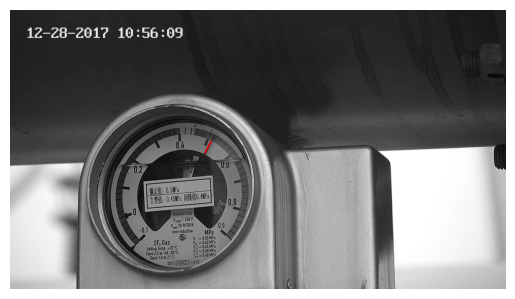

start to test res/2_
0.52
读数 = 0.52MPa


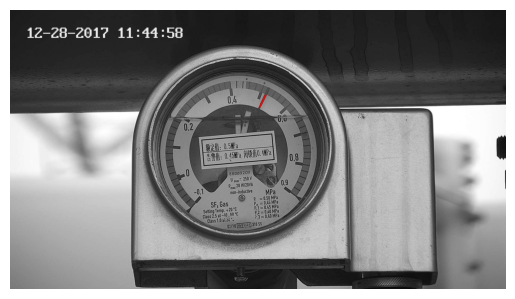

start to test res/3_
0.524
读数 = 0.52MPa


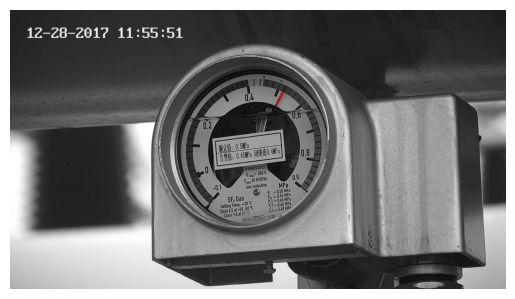

start to test res/4_
0.516
读数 = 0.52MPa


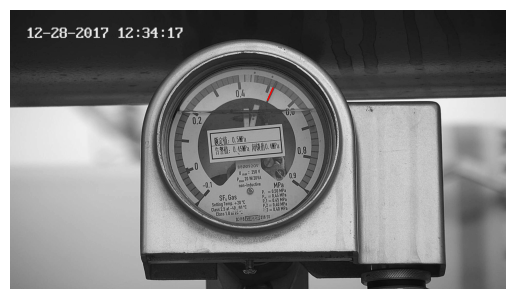

start to test res/5_
0.516
读数 = 0.52MPa


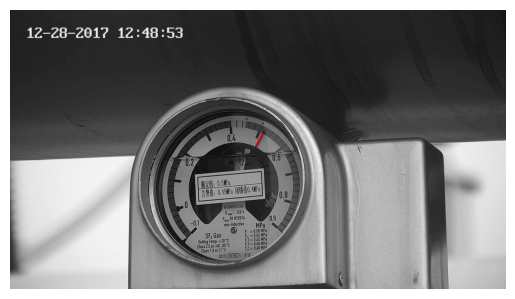

start to test res/6_
0.516
读数 = 0.52MPa


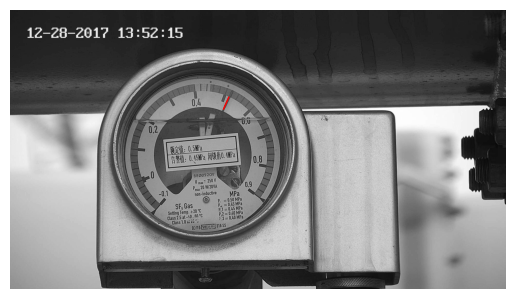

start to test res/7_
0.518
读数 = 0.52MPa


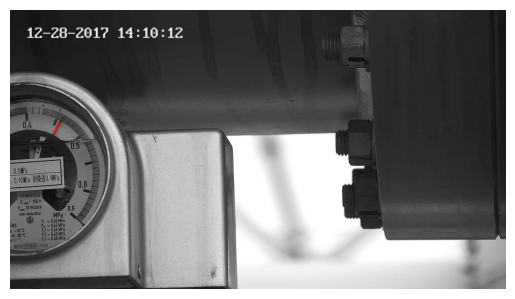

start to test res/8_
0.516
读数 = 0.52MPa


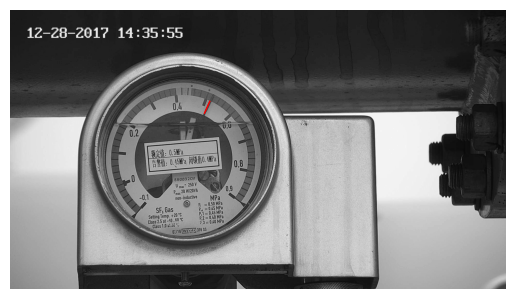

start to test res/9_
0.522
读数 = 0.52MPa


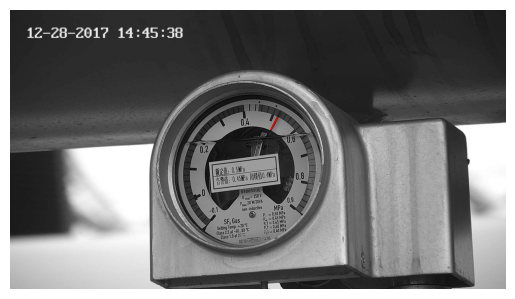

start to test res/10_
0.516
读数 = 0.52MPa


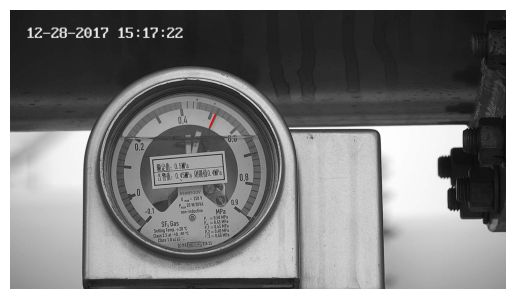

start to test res/11_
0.522
读数 = 0.52MPa


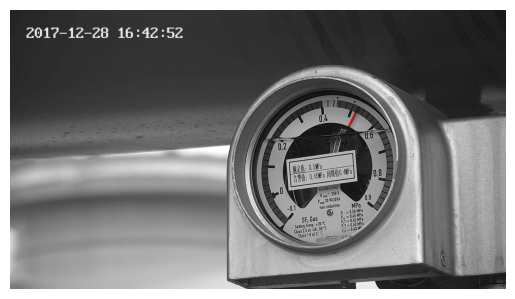

start to test res/12_
0.522
读数 = 0.52MPa


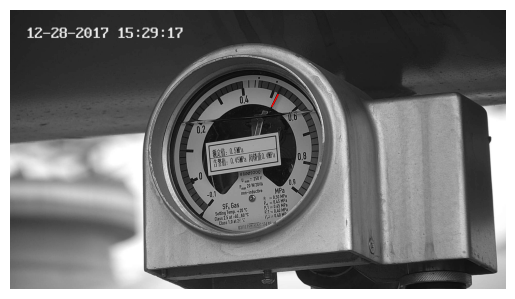

start to test res/13_
0.52
读数 = 0.52MPa


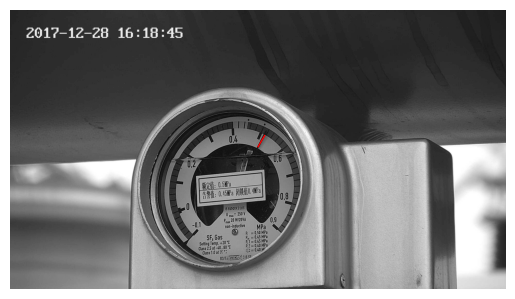

start to test res/14_
0.516
读数 = 0.52MPa


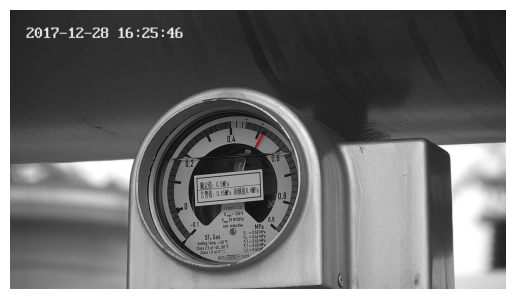

start to test res/15_
0.518
读数 = 0.52MPa


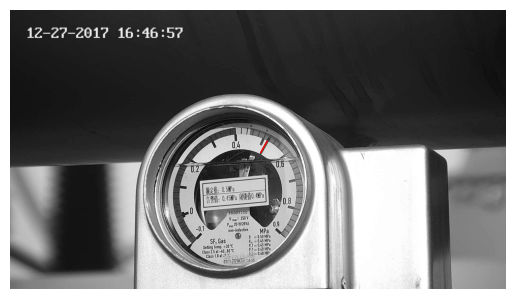

start to test res/16_
0.522
读数 = 0.52MPa


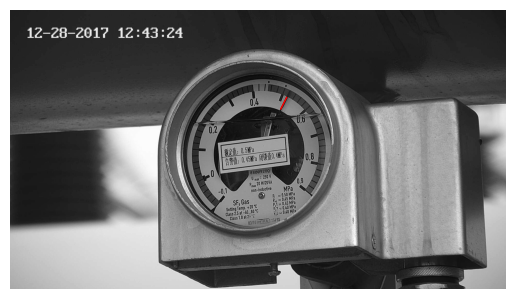

start to test res/17_
0.524
读数 = 0.52MPa


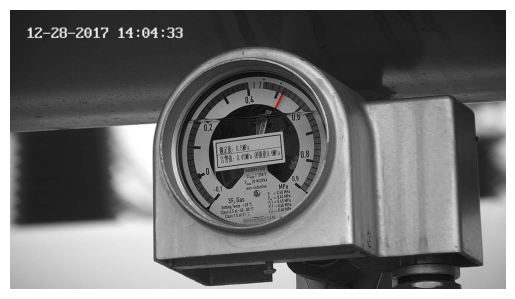

start to test res/18_
0.516
读数 = 0.52MPa


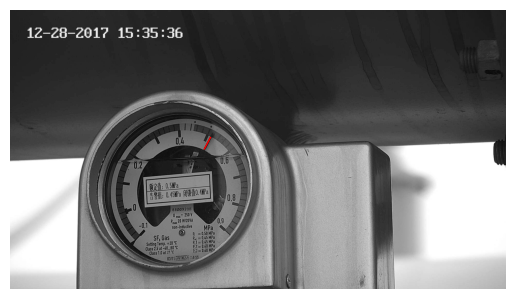

start to test res/19_
0.516
读数 = 0.52MPa


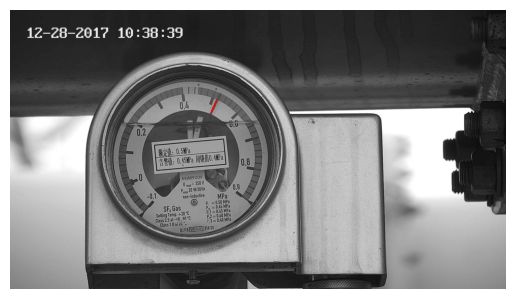

start to test res/20_
0.516
读数 = 0.52MPa


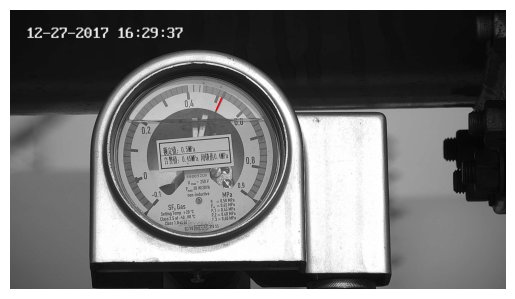

start to test res/21_
0.52
读数 = 0.52MPa


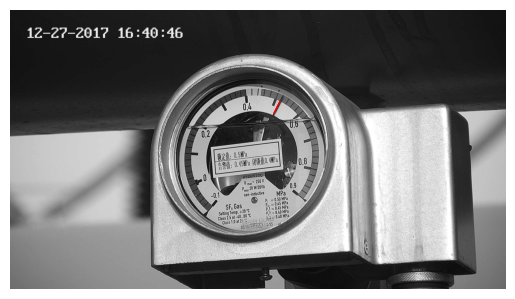

start to test res/22_
0.522
读数 = 0.52MPa


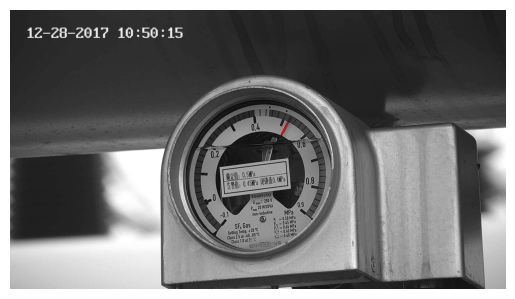

In [269]:
if __name__ == '__main__':

    img1 = cv2.imread('source/template2.jpg')  # 替换为你的第一张图片路径
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    candidate_point = np.array(load_candidate_point('source/template2.jpg'), dtype=np.float32).reshape(-1, 1, 2)

    for number in range(1, 50+1):
        img_path = f'test/test{number}.jpg'

        img2 = cv2.imread(img_path)  # 替换为你的第二张图片路径
        gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        save_path = f'res/{number}_'
        work(candidate_point, gray_img1, gray_img2, save_path)

